本示例演示了一个最常见的基金择时策略的优化过程，在本示例中，我们将演示以下内容：
- 创建一个包含均线择时策略的oeprator对象，该对象包含的策略采用内置的'DMA‘择时策略
- 创建一个Context上下文对象，通过设置context参数，实现策略的优化和回测设置
- 通过对过去15年左右的沪深300指数历史数据，对策略进行参数寻优，最终演示寻优后的结果

## Example Start 示例开始
首先我们导入qteasy模块，为了方便数据的后续处理，同时也导入bumpy和pandas模块
同时，为了在线打印图表，使用`matplotlib inline`设置图表打印模式为在线打印

In [1]:
import sys
sys.path.append('../')
import qteasy as qt
import numpy as np
import pandas as pd
%matplotlib inline

Module qteasy has been loaded successfully!, version: 0.1
tushare version: 1.2.48


### 配置qteasy的基本参数
使用`qt.Context()`创建一个context上下文对象，并进行以下设置：
- 投资回报率的对比数据采用沪深300指数
- 同时设置对比数据的数据类型为“I”

In [2]:
qt.configure(reference_asset = '000300.SH')
qt.configure(ref_asset_type = 'I')

- 设置参与投资组合创建的股票池，因为是纯择时策略，因此设置股票池中只有一个沪深300指数，同样设置资产类型为“I” 指数。

In [3]:
qt.configure(asset_pool = '000300.SH')
qt.configure(asset_type = 'I')

设置投资相关参数：
- moq为0，意味着不存在着必须买卖整数股的条件
- 默认的投资金额为10000元，投入日期为2006年4月6日
- 投资费率是一个Cost对象，以下设置意味着买入费率为千分之一点五，卖出费率为0，没有最低费用的限制，滑点为0

In [4]:
qt.configure(trade_batch_size = 0)
qt.configure(invest_start = '20100105')
qt.configure(invest_end = '20201231')
qt.configure(invest_cash_dates = '20101231')

### 创建Operator对象
使用`qt.Operator()`创建Operator对象。
目前Operator对象尚不支持动态修改其成员策略，因此需要在创建对象时就指定各个策略成员。
该对象的目的是简单择时，因此timing_types设置为一个内置的DMA择时策略，选股策略为ALL，表示选择所有股票池内的投资产品，ricon_types可以选择none即可
这样这个Operator对象就创建完成了，是一个简单DMA择时策略。这个策略有三个参数，通过长、短均线的变化来产生多空仓位信号，一旦多空信号发生变化时，就意味着需要触发交易信号了。

In [5]:
op = qt.Operator(timing_types=['dma'],
                 selecting_types=['all'], ricon_types=['urgent'])

接下来是Operator策略参数的设置。
所有的参数设置都可以使用`operator.set_parameter`方法，可以同时传入多个参数
通过设置策略的opt_tag可以控制策略是否参与优化，而par_boes参数定义了策略优化时需要用到的参数空间
在此时我们并不知道对于过去15年的沪深300指数来说，最优的DMA择时参数是什么，因此可以输入几个随机的参数，进行一次回测，看看结果如何

In [6]:
op.set_parameter('t-0', opt_tag=1, par_boes=[(10, 250), (10, 250), (10, 250)])
op.set_parameter('r-0', opt_tag=0, par_boes=[(5, 14), (-0.2, -0.01)])
op.set_parameter('s-0', pars=(2,), sample_freq='y')

op.set_parameter('t-0', pars=(35, 50, 25))
op.set_parameter('r-0', pars=(8, -0.1443033))

只要将运行模式设置为1，然后`qteasy.run(operator, context)`就可以开始回测了，

为了节省输出空间，我们设置print_log参数为False，关闭回测过程打印，
运行回测后，回测结果如下：

回测最终资产为1.9万元，年化收益率只有4.6%，夏普率只有0.072，收益率显著低于对比指数沪深300

In [7]:
qt.run(op, 
       mode=1, 
       print_backtest_log=True,
       parallel=False,
      hist_data_channel='online')

Progress: [----------------------------------------] 0/1. 0.0%  process parameters submit to get_bar in parallel mode, with parameters:
share = ['000300.SH']
start = 20081126
end   = 20201231
asset_type = I
freq = d
got result from futures, got f:
<Future at 0x7fd3532ac240 state=finished raised BrokenProcessPool>


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

### 单择时策略的优化
显然，没有经过优化的参数无法得到理想的回测结果，因此我们需要进行一次优化

通过设置context对象的各个参数，我们可以设置优化方式并控制优化过程：
以下参数的含义分别如下：

- 优化方法设置为1，使用蒙特卡洛优化，对于较大的参数空间有较好的寻优能力
- 输出结果数量设置为30
- 优化过程迭代次数为1000次
- parallel参数设置为True会使用多核处理器的所有核心进行并行计算节省时间

最后开始优化，使用`perfs_dma`和`pars_dma`两个变量来存储优化结果
优化过程中会显示进度条，结束后会显示优化结果

In [19]:
perfs_dma, pars_dma = qt.run(op, 
                             mode=2,
                             opti_method=1,
                             opti_method_sample_size=1000,
                             parallel=True)

KeyError: 'Unrecognized kwarg=opti_method_sample_size'

优化结束后，可以看到三十组最佳参数，其中最差的一组也能实现最终资产6万元以上。我们可以手动选取其中最佳的参数，再进行一次回测：

能发现终值从上次回测的1.9万暴涨至12.4万，年化收益18.9%，夏普率也上升到了0.833

Getting price type historical data...
Getting price type historical data...
       RUNNING IN MODE 1
      --Back-looping Mode--

|                                  |
|          LOOPING RESULT          |
|                                  |

qteasy running mode: 1 - History back looping
time consumption for operate signal creation: 86.8ms ms
time consumption for operation back looping: 92.9ms ms

investment starts on 2006-04-03 00:00:00
ends on 2020-10-20 00:00:00
Total looped periods: 14.6 years.
operation summary:
            sell  buy  total
000300.SH    55   53    108
Total operation fee:     ¥   5,089.22
total investment amount: ¥  10,000.00
final value:             ¥ 124,675.92
Total return: 1246.759% 
Average Yearly return rate:  18.865%
Total reference return: 344.118% 
Average Yearly reference return rate: 10.783%
strategy performance indicators: 
alpha:               0.083
Beta:                0.982
Sharp ratio:         0.833
Info ratio:          0.016
250 day volatility:  0.

0.8329162967071512

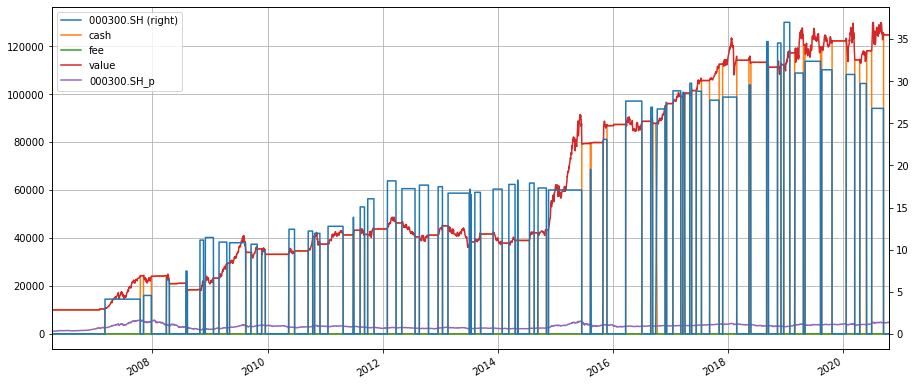

In [9]:
cont.mode = 1
op.set_parameter('t-0', pars=(180, 195, 18))
qt.run(op, cont)

### 择时策略的进一步改进——多重择时
由于择时策略具备一定的随机性，在历史过程中某一个策略并不会总是表现好，而会时而表现好，时而表现差，因此，如果我们同时使用多个参数不同的策略来共同生成择时买卖信号，这样能够形成类似于“委员会”的效果，可能使择时信号在整个时段上都表现较好。

下面，我们就可以创建这样一个多重择时策略，通过多个策略的平均信号或多重信号来进行买卖，看看相对于单一择时策略，能有多少性能提升。

#### 建立多重择时策略

我们可以建立一个包含8个相同的DMA择时策略的operator对象，并对它进行参数设置。

为了在优化过程中充分利用上一步优化的结果，我们可以设置策略的opt_tag参数为2，并将上一次找到的三十组较优参数设置为参数空间，这样下一次优化的时候，将仅从上次优化的结果中选取参数，而忽略其他的参数。

同样设置好基本参数后，可以直接开始优化过程（优化过程忽略）
优化后，我们找到了一组最优参数组，这个参数组中包含了八组DMA参数，需要分别将这八组参数分别赋予operator对象中的八个DMA择时策略

In [11]:
print(f'===============SEARCHING FOR COMBINED PARAMS==================\n'
      f'==============================================================')
op = qt.Operator(timing_types=['dma', 'dma', 'dma', 'dma', 'dma', 'dma', 'dma', 'dma'],
                 selecting_types=['all'], ricon_types=['urgent'])
op.set_parameter('s-0', pars=(2,), sample_freq='y')
op.set_parameter('t-0', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-1', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-2', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-3', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-4', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-5', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-6', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-7', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('r-0', opt_tag=0, par_boes=[(5, 14), (-0.2, -0.01)])

op.set_blender('ls', 'none')
op.set_parameter(stg_id='t-0', pars=(143, 153, 74))
op.set_parameter(stg_id='t-1', pars=(145, 201, 25))
op.set_parameter(stg_id='t-2', pars=(145, 161, 53))
op.set_parameter(stg_id='t-3', pars=(105, 132, 95))
op.set_parameter(stg_id='t-4', pars=(103, 118, 70))
op.set_parameter(stg_id='t-5', pars=(96, 108, 72))
op.set_parameter(stg_id='t-6', pars=(108, 121, 94))
op.set_parameter(stg_id='t-7', pars=(139, 141, 115))
op.set_parameter('r-0', pars=(8, -0.1443033))

===============SEARCHING FOR COMBINED PARAMS==================


### 最终结果
设置好优化完成的参数后，进行一次回测，检查结果：

与单个DMA策略的最终结果相比，多重择时策略的提升是巨大的：

资产终值达到了39.7万元，年化收益达到了28.7%，夏普率达到了1.877！
充分说明了多重择时策略的优良性能

Getting price type historical data...
Getting price type historical data...
       RUNNING IN MODE 1
      --Back-looping Mode--



../qteasy/utilfuncs.py:57: RuntimeWarning: invalid value encountered in less
  op = np.where(op < 0, (op / np.roll(lst, shift=1, axis=1)), op)
../qteasy/utilfuncs.py:57: RuntimeWarning: divide by zero encountered in true_divide
  op = np.where(op < 0, (op / np.roll(lst, shift=1, axis=1)), op)
../qteasy/utilfuncs.py:57: RuntimeWarning: invalid value encountered in true_divide
  op = np.where(op < 0, (op / np.roll(lst, shift=1, axis=1)), op)


|                                  |
|          LOOPING RESULT          |
|                                  |

qteasy running mode: 1 - History back looping
time consumption for operate signal creation: 601.2ms ms
time consumption for operation back looping: 168.9ms ms

investment starts on 2006-04-03 00:00:00
ends on 2020-10-20 00:00:00
Total looped periods: 14.6 years.
operation summary:
            sell  buy  total
000300.SH    96   96    192
Total operation fee:     ¥  19,991.12
total investment amount: ¥  10,000.00
final value:             ¥ 397,159.90
Total return: 3971.599% 
Average Yearly return rate:  28.682%
Total reference return: 344.118% 
Average Yearly reference return rate: 10.783%
strategy performance indicators: 
alpha:               0.180
Beta:                1.000
Sharp ratio:         1.877
Info ratio:          0.043
250 day volatility:  0.134
Max drawdown:        26.971% on 2008-09-17 00:00:00

===========END OF REPORT=============



1.8774782585371528

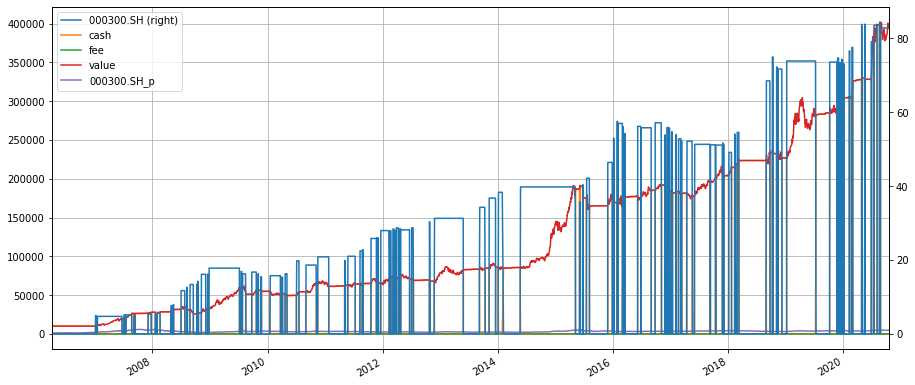

In [12]:
cont.mode = 1
cont.opti_method = 1
cont.opti_method_sample_size = 1000
cont.opti_method_step_size = 1
cont.print_log = False
qt.run(op, cont)